In [1]:
# !pip install medmnist
# !pip install torchinfo

In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
from torchinfo import summary

import medmnist
from medmnist import INFO, Evaluator

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

import torch.nn.utils.prune as prune
import torch.nn.functional as F

In [3]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/


# DATA

In [4]:
# data_flag = 'pathmnist'
data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

#### Data Prep

In [5]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download, size=28, mmap_mode='r')

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /home/soumya/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/soumya/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/soumya/.medmnist/breastmnist.npz


In [6]:
x, y = train_dataset[0]

# Model - No Compression

In [7]:
class ResNet(nn.Module):
    def __init__(self, num_classes, in_channels=1):
        super(ResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        # Modify the first layer to accept in_channels
        self.resnet.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1, bias=False)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x

model = ResNet(num_classes=n_classes, in_channels=n_channels)
model = model.cuda()


In [8]:
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [9]:
# Train

In [10]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs.cuda())
        targets = targets.cuda()
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 18/18 [00:00<00:00, 112.73it/s]


In [11]:
# Test

In [12]:
split = 'test'

model.eval()
y_true = torch.tensor([])
y_score = torch.tensor([])

data_loader = train_loader_at_eval if split == 'train' else test_loader

with torch.no_grad():
    for inputs, targets in data_loader:
        inputs = inputs.cuda()
        outputs = model(inputs)
        outputs = outputs.softmax(dim=-1)
        y_score = torch.cat((y_score, outputs.cpu()), 0)

    y_score = y_score.detach().numpy()
    
    evaluator = Evaluator(data_flag, split, size=224)
    metrics = evaluator.evaluate(y_score)

    print('%s  auc: %.3f  acc: %.3f' % (split, *metrics))

test  auc: 0.750  acc: 0.699


# Model - Compression

In [13]:
class ResNet(nn.Module):
    def __init__(self, num_classes, in_channels=1):
        super(ResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        # Modify the first layer to accept in_channels
        self.resnet.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1, bias=False)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x

model = ResNet(num_classes=n_classes, in_channels=n_channels)
pruned_model = model.cuda()

In [14]:
pruned_model

ResNet(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [15]:
summary(pruned_model, input_size=(BATCH_SIZE, 1, 28, 28)) # Everything in MEDMNIST is 28x28

Layer (type:depth-idx)                        Output Shape              Param #
ResNet                                        [32, 2]                   --
├─ResNet: 1-1                                 [32, 2]                   --
│    └─Conv2d: 2-1                            [32, 64, 14, 14]          576
│    └─BatchNorm2d: 2-2                       [32, 64, 14, 14]          128
│    └─ReLU: 2-3                              [32, 64, 14, 14]          --
│    └─MaxPool2d: 2-4                         [32, 64, 7, 7]            --
│    └─Sequential: 2-5                        [32, 64, 7, 7]            --
│    │    └─BasicBlock: 3-1                   [32, 64, 7, 7]            73,984
│    │    └─BasicBlock: 3-2                   [32, 64, 7, 7]            73,984
│    └─Sequential: 2-6                        [32, 128, 4, 4]           --
│    │    └─BasicBlock: 3-3                   [32, 128, 4, 4]           230,144
│    │    └─BasicBlock: 3-4                   [32, 128, 4, 4]           295,424


#### unstructred prunning

In [16]:
# module = pruned_model.resnet.layer4[1].conv2
# print(list(module.named_parameters()))

In [17]:
# prune.random_unstructured(module, name="weight", amount=0.3)

In [18]:
summary(pruned_model, input_size=(BATCH_SIZE, 1, 28, 28)) # Everything in MEDMNIST is 28x28

Layer (type:depth-idx)                        Output Shape              Param #
ResNet                                        [32, 2]                   --
├─ResNet: 1-1                                 [32, 2]                   --
│    └─Conv2d: 2-1                            [32, 64, 14, 14]          576
│    └─BatchNorm2d: 2-2                       [32, 64, 14, 14]          128
│    └─ReLU: 2-3                              [32, 64, 14, 14]          --
│    └─MaxPool2d: 2-4                         [32, 64, 7, 7]            --
│    └─Sequential: 2-5                        [32, 64, 7, 7]            --
│    │    └─BasicBlock: 3-1                   [32, 64, 7, 7]            73,984
│    │    └─BasicBlock: 3-2                   [32, 64, 7, 7]            73,984
│    └─Sequential: 2-6                        [32, 128, 4, 4]           --
│    │    └─BasicBlock: 3-3                   [32, 128, 4, 4]           230,144
│    │    └─BasicBlock: 3-4                   [32, 128, 4, 4]           295,424


In [19]:
#Decrease in size after pruning

#### loss

In [20]:
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(pruned_model.parameters(), lr=lr, momentum=0.9)

In [21]:
# Train

In [22]:
for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0

    pruned_model.train()
    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = pruned_model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

100%|██████████| 18/18 [00:00<00:00, 112.13it/s]


In [23]:
# Test

In [24]:
def test(split):
    pruned_model.eval()
    y_true = torch.tensor([]).cuda()  # Initialize y_true on GPU
    y_score = torch.tensor([]).cpu()   # Initialize y_score on CPU

    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = pruned_model(inputs)

            if task == 'multi-label, binary-class':
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.resize_(len(targets), 1)
                
            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs.cpu()), 0)  # Move outputs to CPU for concatenation

        y_true = y_true.cpu().numpy()  # Move y_true back to CPU for numpy conversion
        y_score = y_score.numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))


print('==> Evaluating ...')
test('train')
test('test')


==> Evaluating ...
train  auc: 0.585  acc:0.634
test  auc: 0.560  acc:0.622


# Explainability - CAM

In [25]:
# !pip install torchcam

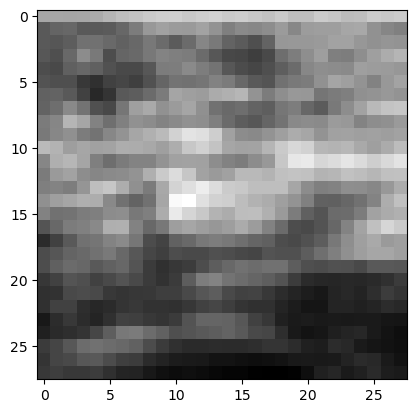

In [26]:
plt.imshow(train_dataset[0][0][0], cmap='gray')

In [29]:
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
from torchcam.methods import SmoothGradCAMpp

model = model.cuda()

# Get your input
img = train_dataset[0][0]
print(img.shape)

# Preprocess it for your chosen model
# input_tensor = normalize(img / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

input_tensor = img.unsqueeze(0).cuda()

torch.Size([1, 28, 28])


In [30]:
with SmoothGradCAMpp(model) as cam_extractor:
  # Preprocess your data and feed it to the model
  out = model(input_tensor.unsqueeze(0))
  # Retrieve the CAM by passing the class index and the model output
  activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

RuntimeError: Given groups=1, weight of size [64, 1, 3, 3], expected input[1, 3, 224, 224] to have 1 channels, but got 3 channels instead

In [ ]:
import matplotlib.pyplot as plt
# Visualize the raw CAM
plt.imshow(activation_map[0].squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

# SIMILARITY - CKA

In [ ]:
# !pip install torch_cka
from torch_cka import CKA

In [ ]:
model1 = model 
model2 = pruned_model 

dataloader = train_loader

cka = CKA(model1, model2,
          model1_name="normal",   # good idea to provide names to avoid confusion
          model2_name="pruned",   
          device='cuda')

cka.compare(dataloader) # secondary dataloader is optional

results = cka.export()  # returns a dict that contains model names, layer names
                        # and the CKA matrix

| Comparing features |: 100%|██████████| 18/18 [00:25<00:00,  1.39s/it]


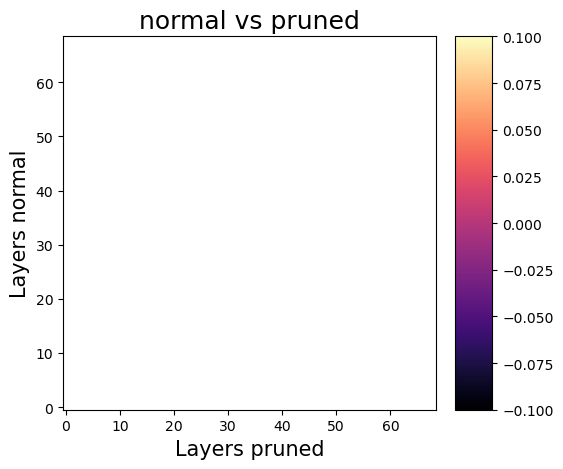

In [ ]:
plot = cka.plot_results()  # returns a heatmap of the CKA matrix  

In [ ]:
# https://pytorch.org/tutorials/intermediate/pruning_tutorial.html#pruning-a-module

# #todo

# 1. Prune the model
# 2. Similarity
# 3. Visualization
# 4. Explainability